### Install & Import Libraries

In [34]:
# !pip install opencv-python scikit-learn scikit-image matplotlib pandas numpy

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import graycomatrix, graycoprops

# Set random seed for reproducibility
np.random.seed(42)

### Define Pipeline Functions

This section implements the specific logic from your flowchart.

1. Preprocessing: Resizing and RGB → HSV conversion.

2. Segmentation: Using Canny Edge Detection and Thresholding to isolate the leaf.

3. Feature Extraction: Calculating Hu Moments (Shape) and Haralick Texture features.

In [35]:
from scipy.stats import skew

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Step 1 & 2: Upload & Image Preprocessing
    - Reads image
    - Resizes image
    - Converts RGB to HSV
    """
    img = cv2.imread(image_path)
    if img is None:
        return None, None
    
    # Resizing
    img_resized = cv2.resize(img, target_size)
    
    # Conversion RGB to HSV (as per flowchart)
    img_hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
    
    # We also keep a grayscale version for texture analysis
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    return img_resized, img_hsv, img_gray

def segment_image(img_gray):
    """
    Step 3: Image Segmentation
    - Applies Edge Detection (Canny)
    - Creates a binary mask (Thresholding)
    """
    # Edge Detection (as per flowchart)
    edges = cv2.Canny(img_gray, 100, 200)
    
    # Thresholding to get the binary mask of the leaf structure
    _, binary_mask = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    return edges, binary_mask

def extract_features(img_hsv, img_gray, binary_mask):
    """
    Updated Feature Extraction:
    1. Shape (Hu Moments)
    2. Texture (Haralick)
    3. Color (Mean, Std, Skew of HSV channels) -> NEW & CRITICAL
    """
    
    # --- 1. Hu Moments (Shape) ---
    moments = cv2.moments(binary_mask)
    hu_moments = cv2.HuMoments(moments).flatten()
    # Log scale for stability
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
    
    # --- 2. Haralick Features (Texture) ---
    glcm = graycomatrix(img_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    
    haralick_features = np.array([contrast, dissimilarity, homogeneity, energy, correlation])
    
    # --- 3. Color Moments (Color) [THE IMPROVEMENT] ---
    # We calculate the Mean, Standard Deviation, and Skewness for H, S, and V channels
    # H (Hue) helps distinguishing Green vs Brown/Yellow
    # S (Saturation) helps distinguishing the intensity of the disease
    h, s, v = cv2.split(img_hsv)
    
    color_features = []
    for channel in [h, s, v]:
        color_features.append(np.mean(channel)) # Average color
        color_features.append(np.std(channel))  # Variation in color
        color_features.append(skew(channel.flatten())) # Distribution of color
    
    color_features = np.array(color_features)

    # --- Combine All ---
    global_feature = np.hstack([hu_moments, haralick_features, color_features])
    
    return global_feature

### Load Data and Create Dataset

In [36]:
# --- Configuration ---
# UPDATE THIS PATH to your dataset folder
dataset_path = "Data/Potato-Dataset" 

categories = ["Potato-Early-Blight", "Potato-Late-Blight", "Potato-Healthy"]
data = []
labels = []

print("Starting Data Loading and Feature Extraction...")

for category in categories:
    path = os.path.join(dataset_path, category)
    class_num = categories.index(category) # 0, 1, or 2
    
    # Check if directory exists
    if not os.path.exists(path):
        print(f"Warning: Directory not found {path}. Skipping.")
        continue
        
    for img_name in os.listdir(path):
        try:
            img_path = os.path.join(path, img_name)
            
            # 1. Preprocess
            img_resized, img_hsv, img_gray = preprocess_image(img_path)
            if img_resized is None: continue
            
            # 2. Segment
            edges, binary_mask = segment_image(img_gray)
            
            # 3. Extract Features
            features = extract_features(img_hsv, img_gray, binary_mask)
            
            # Append to dataset
            data.append(features)
            labels.append(class_num)
            
        except Exception as e:
            print(f"Error processing {img_name}: {e}")

print(f"Feature Extraction Completed. Processed {len(data)} images.")

# Convert to NumPy arrays
X = np.array(data)
y = np.array(labels)

# Check shape
print(f"Feature Matrix Shape: {X.shape}")

Starting Data Loading and Feature Extraction...
Feature Extraction Completed. Processed 2152 images.
Feature Matrix Shape: (2152, 21)


### Classification (Random Forest)

In [37]:
# Split data into Training and Testing sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Classifier
# n_estimators=100 is standard, comparable to the flowchart's classification step
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

print("Training Random Forest Model...")
rf_model.fit(X_train, y_train)
print("Training Completed.")

Training Random Forest Model...
Training Completed.


### Evaluation & Prediction

Model Accuracy: 93.50%

Classification Report:
                     precision    recall  f1-score   support

Potato-Early-Blight       0.97      0.94      0.96       196
 Potato-Late-Blight       0.89      0.97      0.93       198
     Potato-Healthy       1.00      0.68      0.81        37

           accuracy                           0.94       431
          macro avg       0.96      0.86      0.90       431
       weighted avg       0.94      0.94      0.93       431



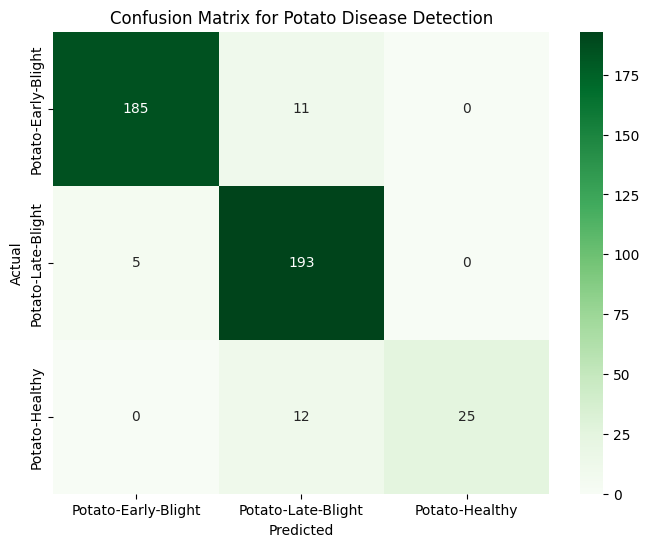

In [38]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Potato Disease Detection')
plt.show()